# Configuração inicial:

Vamos começar importando algumas bibliotecas

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
!pip install gdown

Vamos agora fixar o sorteio aleatório de números no nosso projeto. Observa que isso é importante para que possamos reproduzir o modelo.

In [2]:
seed = 42
np.random.seed(seed)

Vamos agora importar módulo básicos do matplotlib para plotar figuras:

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

É comum que alarmes sejam disparados quando há algum erro interno ao rodar os códigos. Em geral é importante manter eles ligados pois podem nos ajudar a identificar possíveis erros no código.

Por hora vamos desligar alguns warnings desnecessários relacionados ao 'internal gelsd':

In [4]:
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Obtendo os dados:


Obtendo os dados sobre estimativas de câncer no Brasil:

In [5]:
import gdown
import pandas as pd

file_id = '1MUeej51WUUtMZnpapaP6MG-P33GpG47A'

url = f'https://drive.google.com/uc?export=download&id={file_id}'

gdown.download(url, 'dados.csv', quiet=False)

cancerdata = pd.read_csv('dados.csv', encoding='latin-1')


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1MUeej51WUUtMZnpapaP6MG-P33GpG47A
From (redirected): https://drive.google.com/uc?export=download&id=1MUeej51WUUtMZnpapaP6MG-P33GpG47A&confirm=t&uuid=4235f54b-d279-404c-99aa-89098f88b4ef
To: /content/dados.csv
100%|██████████| 626M/626M [00:12<00:00, 49.7MB/s]
<ipython-input-5-9a06e751d6ff>:10: DtypeWarning: Columns (3,5,6,7,8,9,10,13,14,23,24,25,27,28,29,30,31,32,33,34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  cancerdata = pd.read_csv('dados.csv', encoding='latin-1')


Obtendo os dados sobre dados populacionais estimados de cidades do Brasil:

In [6]:
import gdown
import pandas as pd

file_id = '1edocBvR63QzdNqkyhQpqz-ZxcSUJr_de'

url = f'https://drive.google.com/uc?export=download&id={file_id}'

gdown.download(url, 'dados.csv', quiet=False)

municipio = pd.read_csv('dados.csv')

Downloading...
From: https://drive.google.com/uc?export=download&id=1edocBvR63QzdNqkyhQpqz-ZxcSUJr_de
To: /content/dados.csv
100%|██████████| 3.64M/3.64M [00:00<00:00, 119MB/s]


Importando o CSV com os códigos de munícipio indicando qual o munícipio (https://github.com/leogermani).

In [7]:
import pandas as pd

url = 'https://raw.githubusercontent.com/leogermani/estados-e-municipios-ibge/refs/heads/master/municipios.csv'

codigomunicipios = pd.read_csv(url)

Adicionando a cidade a tabela de municipios:

In [8]:
municipios = pd.merge(municipio, codigomunicipios, left_on='id_municipio', right_on='COD')
municipios.drop(columns=['COD'], inplace=True)

municipios.head()

,ano,sigla_uf,id_municipio,populacao,COD UF,NOME
0,1991,RO,1100015,31981.0,11,Alta Floresta D'oeste
1,1992,RO,1100015,34768.0,11,Alta Floresta D'oeste
2,1993,RO,1100015,37036.0,11,Alta Floresta D'oeste
3,1994,RO,1100015,39325.0,11,Alta Floresta D'oeste
4,1995,RO,1100015,41574.0,11,Alta Floresta D'oeste


# Conheçendo os dados - Cancer Data:

In [9]:
print(cancerdata.head())

   Patient.Code              RCBP.Name     Gender Date.of.Birth   Age  \
0      672054.0  RCBP CAMPINAS-UNICAMP  MASCULINO    1975-03-16  30.0   
1      673213.0  RCBP CAMPINAS-UNICAMP   FEMININO    1950-05-24  53.0   
2      673396.0  RCBP CAMPINAS-UNICAMP   FEMININO    1951-09-02  51.0   
3      673425.0  RCBP CAMPINAS-UNICAMP   FEMININO    1929-11-21  73.0   
4      673745.0  RCBP CAMPINAS-UNICAMP  MASCULINO    1934-07-03  71.0   

  Raca.Color Nationality Naturality.State Naturality Degree.of.Education  ...  \
0     BRANCO      BRASIL        SÃO PAULO        NaN                 NaN  ...   
1        NaN         NaN              NaN        NaN                 NaN  ...   
2      PARDA      BRASIL        SÃO PAULO        NaN                 NaN  ...   
3        NaN         NaN              NaN        NaN                 NaN  ...   
4     BRANCO      BRASIL        SÃO PAULO        NaN                 NaN  ...   

  Laterality  Statement  TNM Status.Vital Type.of.Death Date.of.Death  \
0

Observa que todas as 5 primeiras amostras tem **RCBP.Name = 'CAMPINAS-UNICAMP'**, o que pode indicar que os dados estejam de certa forma ordenados.

Vamos fazer então o seguinte: vamos coletar uma amostra contendo 10 instâncias para visualizar os nossos dados. Observa que esse processo envolve uma aleatoriedade, daí a importância de fixar random_state em um certo valor caso você tenha interesse em reproduzir o experimento.

In [10]:
cancerdata.sample(n = 10, random_state = seed)

,Patient.Code,RCBP.Name,Gender,Date.of.Birth,Age,Raca.Color,Nationality,Naturality.State,Naturality,Degree.of.Education,...,Laterality,Statement,TNM,Status.Vital,Type.of.Death,Date.of.Death,Date.of.Last.Contact,Date.of.Diagnostic,Distant.metastasis,year
1317338,1037951.0,RCBP BELO HORIZONTE,MASCULINO,2001-08-26,11.0,PARDA,BRASIL,NaN,NaN,NaN,...,NaN,NaN,NaN,MORTO,CÂNCER,2012-09-30,2012-09-30,2012-09-30,NaN,2012.0
1037369,901210.0,RCBP SÃO PAULO,FEMININO,NaN,74.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2013-04-06,NaN,2011-02-08,NaN,2011.0
316024,665856.0,RCBP SÃO PAULO,MASCULINO,NaN,72.0,PARDA,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-04-23,NaN,2003.0
1496253,1299376.0,RCBP MATO GROSSO (INTERIOR),FEMININO,1914-04-02,95.0,BRANCO,BRASIL,PARANÁ,CURITIBA,NaN,...,NaN,NaN,NaN,NaN,NÃO CÂNCER,2011-01-29,NaN,2010-03-29,NaN,2010.0
1328760,1112999.0,RCBP BELO HORIZONTE,MASCULINO,1930-04-27,82.0,NaN,BRASIL,NaN,NaN,NaN,...,NÃO SE APLICA,NaN,NaN,VIVO,NaN,NaN,2013-03-19,2013-03-19,NaN,2013.0
472777,760121.0,RCBP BELO HORIZONTE,MASCULINO,1951-12-27,55.0,BRANCO,BRASIL,MINAS GERAIS,NaN,MÉDIO (ANTIGO SEGUNDO GRAU),...,NaN,NaN,NaN,NaN,CÂNCER,2007-04-01,NaN,2007-03-30,NaN,2007.0
1556098,720781.0,RCBP DRS BARRETOS,FEMININO,1953-11-14,56.0,BRANCO,BRASIL,PARANÁ,ASTORGA,FUNDAMENTAL II (5ª A 8ª SÉRIE),...,NÃO SE APLICA,I,T1N0M0,MORTO,CÂNCER,2016-05-27,2016-05-27,2010-07-29,NaN,2010.0
1589684,554426.0,RCBP FLORIANOPOLIS,MASCULINO,1952-03-15,57.0,BRANCO,BRASIL,PARANÁ,CURITIBA,MÉDIO (ANTIGO SEGUNDO GRAU),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-02-26,NaN,2010.0
850204,343205.0,RCBP TERESINA,MASCULINO,1966-03-04,37.0,PARDA,BRASIL,PIAUÍ,OEIRAS,FUNDAMENTAL II (5ª A 8ª SÉRIE),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004-02-19,NaN,2004.0
566274,422828.0,RCBP DISTRITO FEDERAL,FEMININO,1955-10-20,44.0,PARDA,BRASIL,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-09-08,NaN,2000.0


Vamos agora nos informar a respeito das variáveis da base de dados:

In [11]:
cancerdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1778176 entries, 0 to 1778175
Data columns (total 38 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   Patient.Code                     float64
 1   RCBP.Name                        object 
 2   Gender                           object 
 3   Date.of.Birth                    object 
 4   Age                              float64
 5   Raca.Color                       object 
 6   Nationality                      object 
 7   Naturality.State                 object 
 8   Naturality                       object 
 9   Degree.of.Education              object 
 10  State.Civil                      object 
 11  Code.Profession                  float64
 12  Name.Occupation                  object 
 13  Status.Address                   object 
 14  City.Address                     object 
 15  Description.of.Topography        object 
 16  Topography.Code                  object 
 17  Morpholo

É importante também saber como esse dataset foi construído:

*   Para produzir estimativas de câncer no Brasil, o governo, mais especificamente o Instituto Nacional do Câncer (INCA), tem centros sistemáticos para coleta de dados. Eles são conhecidos como RCBP (Registros de Câncer com Base Populacional). Esses dados estão de acordo com as leis regionais e podem ser exigidos por qualquer pessoa.

Aqui o professor, que forneceu o dataset traduziu as variáveis para ajudar em qualquer análise, mas a maioria dos valores não são traduzidos devido à preguiça 🛏 . No entanto, quase todos os termos são traduzíveis usando o google ou parte de um sistema de código internacional **(CID-10 - - classificação de doenças -- ou CID-O3 -- classificação de cânceres tendo em mente a topografia e a morfologia)**. Mais sobre os termos podem ser vistos aqui:[ www.inca.gov.br/publicacoes/manuais/manual-de-rotinas-e-procedimentos-para-registros-de- cancer-de-base-populacional](https://)


Nesse caso,extrair medidas resumo do nosso conjunto de dados não é efetivo, uma vez que cada linha é um caso:


In [12]:
cancerdata.describe()

,Patient.Code,Age,Code.Profession,Code.of.Morphology,year
count,1.703747e+06,1.698204e+06,1.638026e+06,1.778176e+06,1.714334e+06
mean,7.113482e+05,6.003436e+01,9.726202e+01,8.284179e+04,2.008209e+03
std,3.356102e+05,1.720933e+01,2.173043e+02,4.273058e+03,4.724498e+00
min,1.010000e+02,0.000000e+00,0.000000e+00,8.000000e+04,2.000000e+03
25%,4.483235e+05,4.900000e+01,0.000000e+00,8.070300e+04,2.004000e+03
50%,6.941340e+05,6.200000e+01,0.000000e+00,8.097300e+04,2.009000e+03
75%,9.408085e+05,7.300000e+01,0.000000e+00,8.380300e+04,2.012000e+03
max,1.464035e+06,1.067000e+03,9.920000e+02,9.990300e+04,2.019000e+03


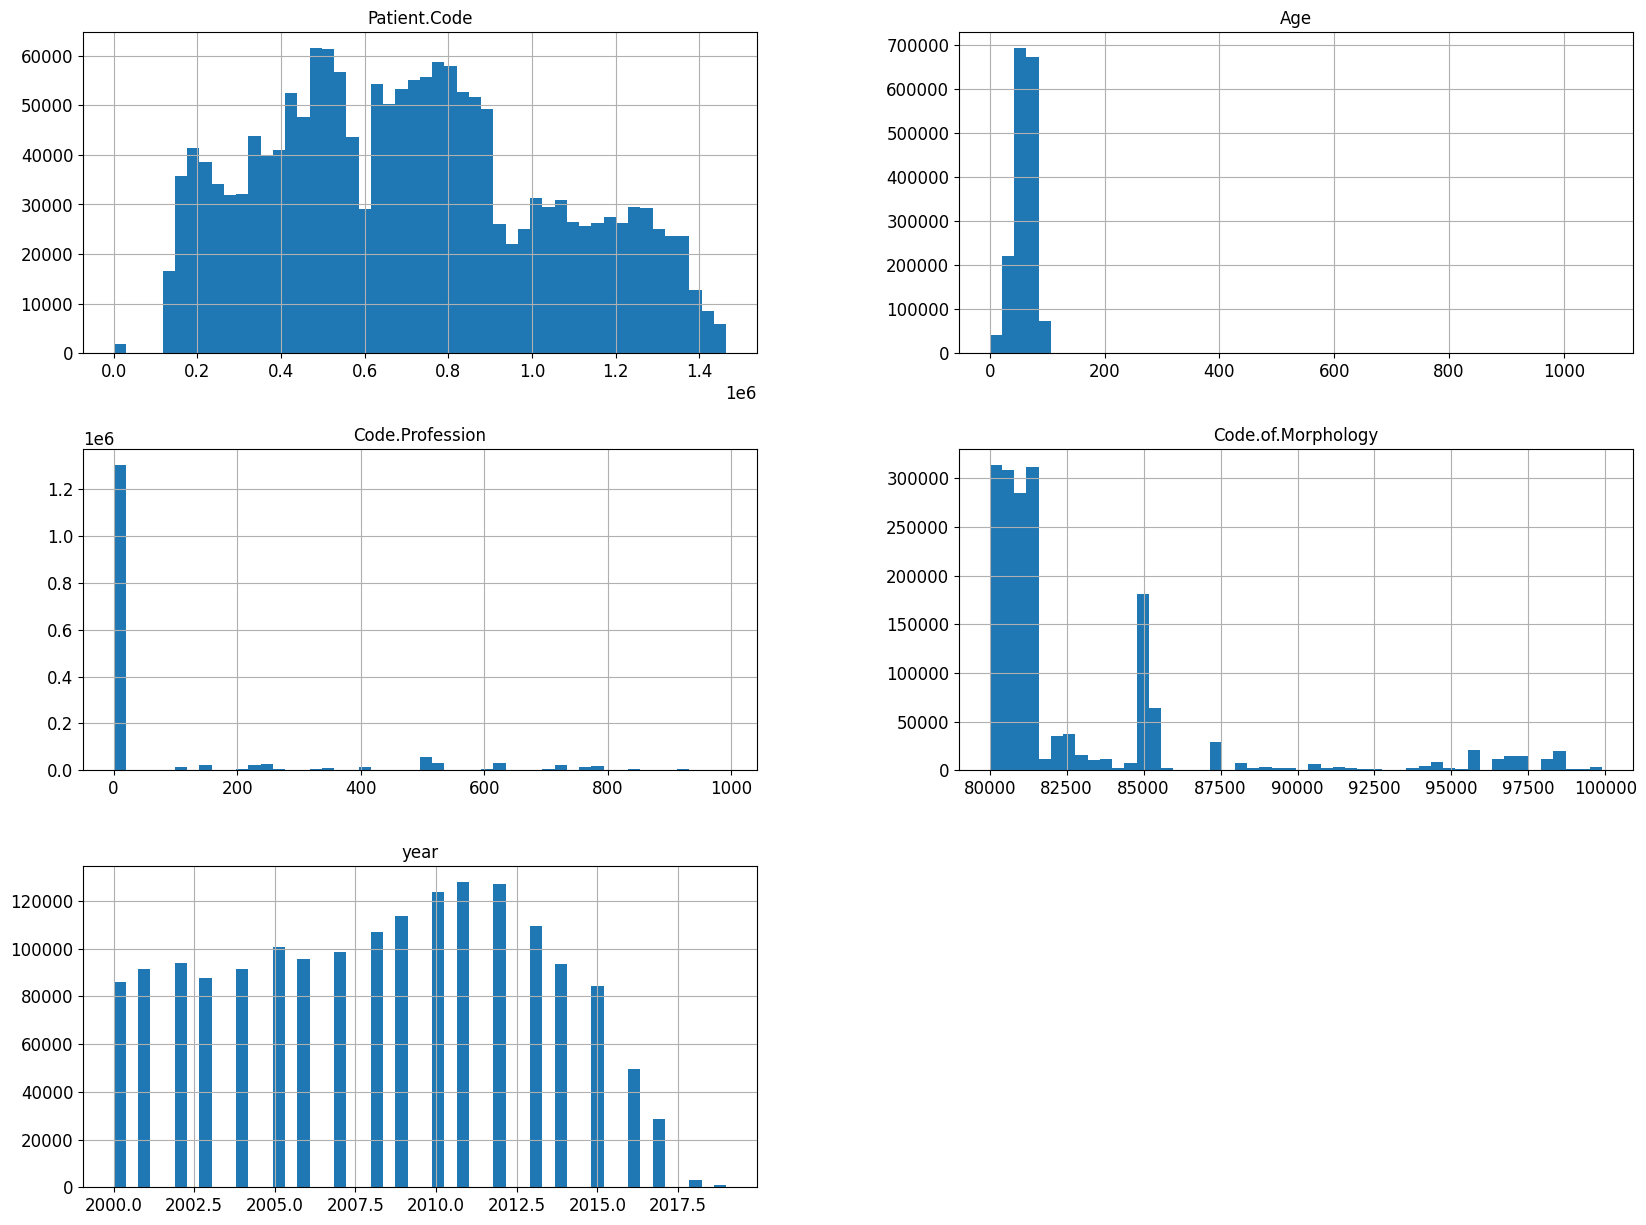

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
cancerdata.hist(bins=50, figsize=(20,15))
plt.show()

Como pode observar, apenas com a análise exploratória básica os dados não fazem muito sentido, né?

Nesse caso, vamos fazer a análise de forma um pouco diferente. Vamos visualizar gráficos com informações relevantes do conjunto,e ao decorrer do projeto responder questões como:

1. Quais cânceres são mais incidentes em quais populações/subpopulações?
2.  Quais cânceres tiveram sua taxa de sobrevivência aprimorada?
3. As pessoas tratam seus cânceres em seu estado ou vão para outros estados? Há alguma tendência relacionada a isso?
4. Alguns centros tratam seus pacientes melhor do que outros? (São suas grandes diferenças no resultado, dependendo de onde a pessoa foi diagnosticada)
5. Quão mal as pessoas preenchem esses formulários? (Quanto NA é o seu? Quanto não específico? Quais variáveis são simplesmente inutilizável?)

# Conhecendo os dados - Municípios:

In [14]:
municipios.head()

,ano,sigla_uf,id_municipio,populacao,COD UF,NOME
0,1991,RO,1100015,31981.0,11,Alta Floresta D'oeste
1,1992,RO,1100015,34768.0,11,Alta Floresta D'oeste
2,1993,RO,1100015,37036.0,11,Alta Floresta D'oeste
3,1994,RO,1100015,39325.0,11,Alta Floresta D'oeste
4,1995,RO,1100015,41574.0,11,Alta Floresta D'oeste


Observa que todas as 5 primeiras amostras tem **sigla_uf = 'RO'**, o que pode indicar que os dados estejam de certa forma ordenados.

Vamos fazer então o seguinte: vamos coletar uma amostra contendo 10 instâncias para visualizar os nossos dados. Observa que esse processo envolve uma aleatoriedade, daí a importância de fixar random_state em um certo valor caso você tenha interesse em reproduzir o experimento.

In [15]:
municipios.sample(n = 10, random_state = seed)

,ano,sigla_uf,id_municipio,populacao,COD UF,NOME
153242,2004,RS,4321451,23661.0,43,Teutônia
147663,2020,RS,4312443,2919.0,43,Morrinhos do Sul
38843,2004,PB,2504157,7092.0,25,Casserengue
94933,2016,ES,3202801,34585.0,32,Itapemirim
140499,2017,RS,4300901,6601.0,43,Aratiba
153630,2007,RS,4321907,23467.0,43,Três Passos
155977,1997,MS,5004700,21387.0,50,Ivinhema
115450,2019,SP,3547809,718773.0,35,Santo André
126452,2012,PR,4117909,29123.0,41,Palotina
47314,2014,PE,2609808,14261.0,26,Orocó


Vamos agora nos informar a respeito das variáveis da base de dados:

In [16]:
municipios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168818 entries, 0 to 168817
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ano           168818 non-null  int64  
 1   sigla_uf      168818 non-null  object 
 2   id_municipio  168818 non-null  int64  
 3   populacao     168284 non-null  float64
 4   COD UF        168818 non-null  int64  
 5   NOME          168818 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 7.7+ MB


É importante também saber como esse dataset foi construído:

* O professor adicionou os dados populacionais estimados de quase todas as cidades do Brasil. Esses dados são produzidos pelo IBGE e foram organizados por Ricardo Dahis (e-mail: rdahis@basedosdados.org | githubuser: rdahis | site:[ www.ricardodahis.com](https://) | ckanuser: rdahis) e podem ser baixados novamente aqui [texto do link](https://basedosdados.org/dataset/br-ibge-populacao)

Novamente, a extração de medidas resumo do nosso conjunto de dados não é efetivo, uma vez que cada linha é um caso:

In [17]:
municipios.describe()

,ano,id_municipio,populacao,COD UF
count,168818.000000,1.688180e+05,1.682840e+05,168818.000000
mean,2006.287689,3.254656e+06,3.359667e+04,32.387867
std,8.829095,9.815392e+05,1.996895e+05,9.800145
min,1991.000000,1.100015e+06,6.520000e+02,11.000000
25%,1999.000000,2.513208e+06,5.316000e+03,25.000000
50%,2006.000000,3.146305e+06,1.104800e+04,31.000000
75%,2014.000000,4.118402e+06,2.313125e+04,41.000000
max,2021.000000,5.300108e+06,1.239637e+07,53.000000


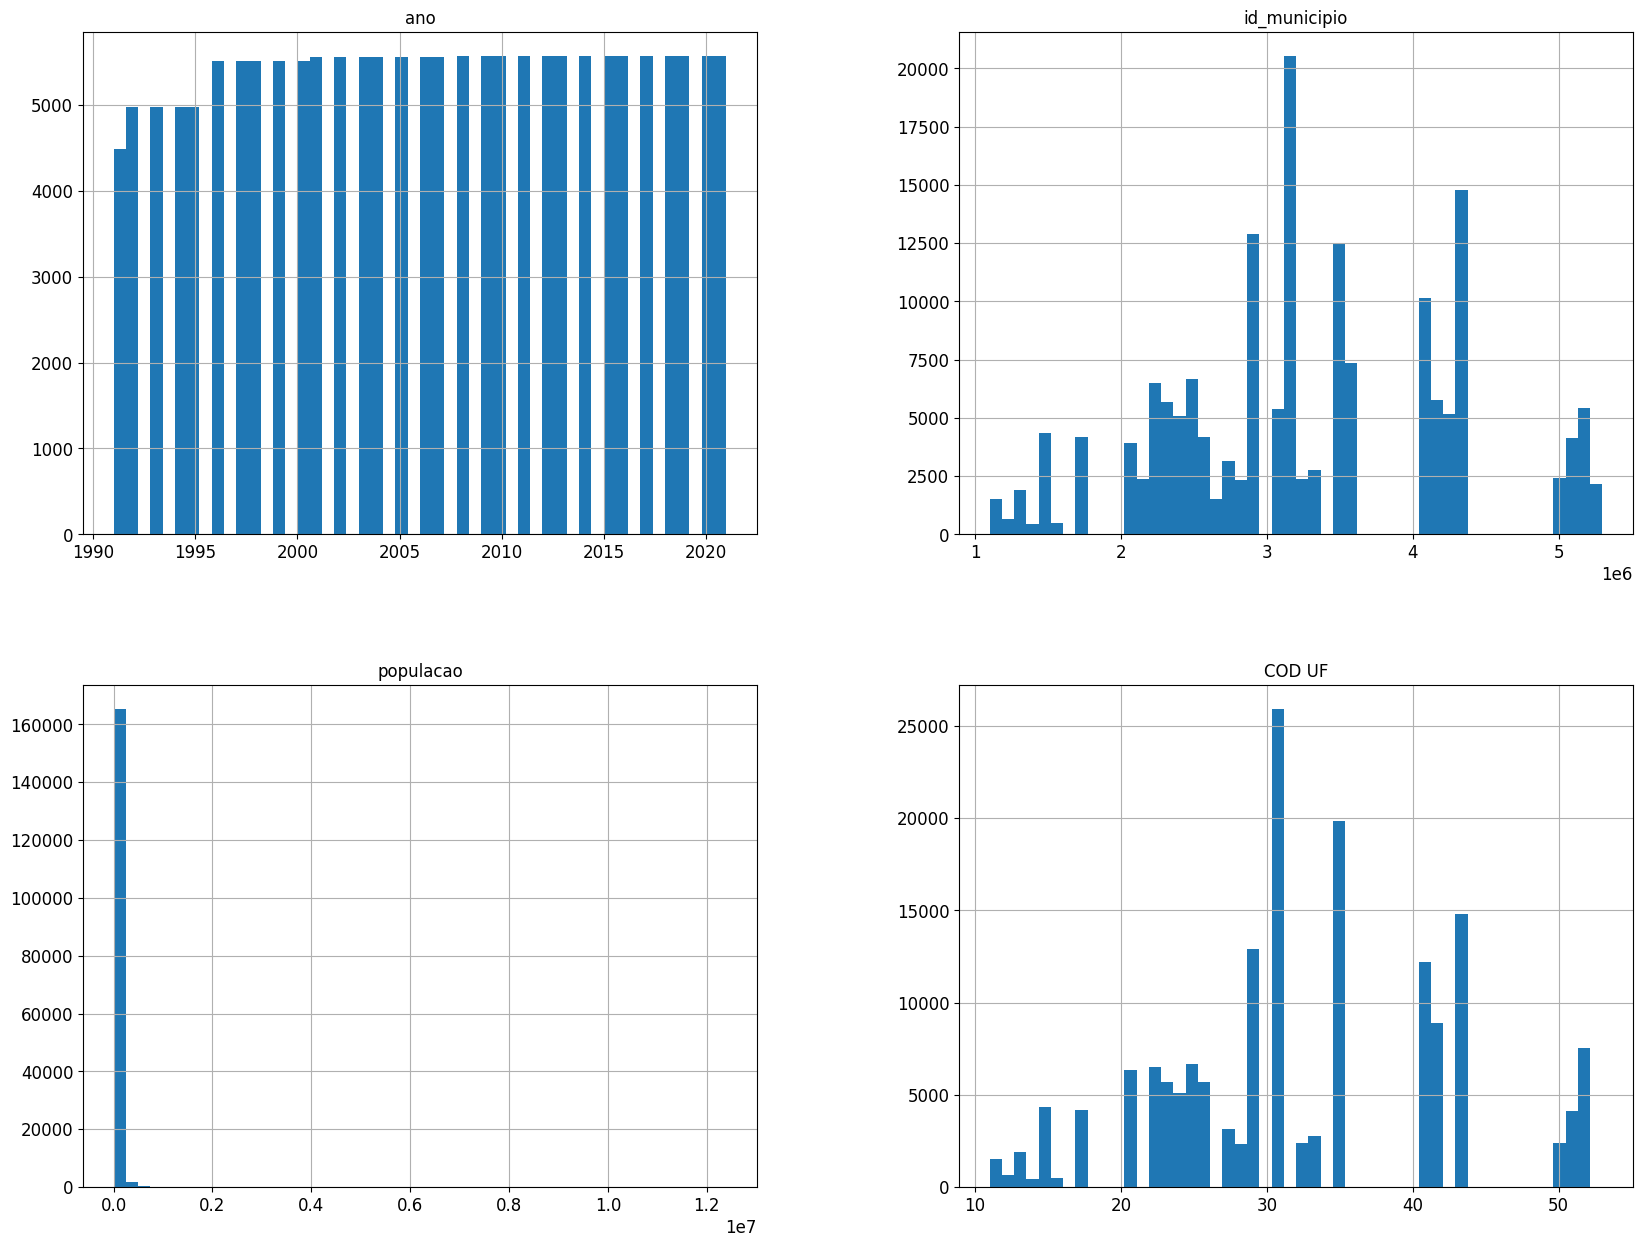

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
municipios.hist(bins=50, figsize=(20,15))
plt.show()

Novamente, assim como nos dados do CancerData, a análise exploratória tradicional não faz muito sentido. Por isso iremos entender um pouco mais do nosso conjunto de dados respondendo algumas perguntas como as citadas anteriormente.


# Perguntas:

Antes de responder as perguntas iremos criar uma cópia dos nossos conjuntos, evitando quaisquer alterações que ocorram neles durante nossa análise.

In [19]:
import pandas as pd

cancerdatacopy = cancerdata.copy()
municipioscopy = municipios.copy()

### Perguntas 1 - Câncer mais incidente por população/subpopulação:

Conseguimos descobrir quais os tipos de câncer mais comum entre cada sexo, e o número de casos total daquele tipo por sexo.

In [20]:
incidentes_por_tipo = cancerdata.groupby(['Gender', 'Description.of.Disease']).size().reset_index(name='Count')
incidentes_por_tipo.sort_values('Count', ascending=False).head(10)


,Gender,Description.of.Disease,Count
939,MASCULINO,PROSTATA,174088
262,FEMININO,"MAMA , SOE",149754
54,FEMININO,"COLO DO UTERO, SOE",112778
388,FEMININO,PELE DE OUTRAS PARTES DA FACE,78603
907,MASCULINO,PELE DE OUTRAS PARTES DA FACE,62153
138,FEMININO,GLANDULA TIREOIDE,45988
563,MASCULINO,"BRONQUIOS OU PULMOES, SOE",41135
642,MASCULINO,"ESTOMAGO, SOE",32131
306,FEMININO,NEOPLASIA MALIGNA DA PELE,31634
826,MASCULINO,NEOPLASIA MALIGNA DA PELE,28653


### Pergunta 2 - Taxa de sobrevivência por tipo de câncer:

Primeiro filtramos apenas pacientes que faleceram devido ao câncer, depois calculamos a diferença em anos entre o diagnóstico e a data de óbito (ou último contato se morto), então aplicamos o filtro de pessoas mortas e calculamos a **média de sobrevivência desses pacientes agrupando por tipo de câncer em anos**:



In [21]:
filtro_mortos_por_cancer = (cancerdata['Status.Vital'] == 'MORTO') & (cancerdata['Type.of.Death'] == 'CÂNCER')

cancerdata['Date.of.Diagnostic'] = pd.to_datetime(cancerdata['Date.of.Diagnostic'], errors='coerce')
cancerdata['Date.of.Last.Contact'] = pd.to_datetime(cancerdata['Date.of.Last.Contact'], errors='coerce')

cancerdata['survival_years'] = ((cancerdata['Date.of.Last.Contact'] - cancerdata['Date.of.Diagnostic']).dt.days / 365).fillna(0)

dados_mortos_por_cancer = cancerdata[filtro_mortos_por_cancer]

sobrevivencia_por_cancer = dados_mortos_por_cancer.groupby('Description.of.Disease')['survival_years'].mean().sort_values(ascending=False)

print(sobrevivencia_por_cancer)



Description.of.Disease
PELE DOS MEMBROS INFERIORES, INCLUINDO QUADRIL    4.417260
PELE DA ORELHA E DO CONDUTO AUDITIVO EXTERNO      4.229589
OLHO                                              4.210959
LABIO, SOE FACE INTERNA                           3.978082
PAREDE SUPERIOR DA NASOFARINGE                    3.935616
                                                    ...   
DOENCA DE LETTERER-SIWE                           0.000000
OUTRAS PARTES DO PANCREAS                        -0.000137
LESAO INVASIVA DO ENCEFALO E S.N.C.              -0.000329
SEIO ESFENOIDAL                                  -0.000548
ANEL DE WALDEYER                                 -0.002740
Name: survival_years, Length: 447, dtype: float64


In [22]:
tabela_sobreviventes = (
    dados_mortos_por_cancer.groupby(['Description.of.Disease', 'year'])
    .size()
    .unstack(fill_value=0)
)

print("Tabela com cada ano como coluna e cada tipo de câncer como linha:")
print(tabela_sobreviventes)

print("\nResumo do número de sobreviventes por tipo de câncer e ano:")
print(tabela_sobreviventes.sum(axis=1))


Tabela com cada ano como coluna e cada tipo de câncer como linha:
year                           2000.0  2001.0  2002.0  2003.0  2004.0  2005.0  \
Description.of.Disease                                                          
ABDOME                              8       5       6       6      11       6   
AMIGDALA LINGUAL                    0       0       0       0       0       0   
AMIGDALA, SOE                       1       3       3       5       0       2   
AMPOLA DE VATER                     3       1       3       0       3       4   
ANEL DE WALDEYER                    0       0       0       0       0       0   
...                               ...     ...     ...     ...     ...     ...   
VESTIBULO DA BOCA                   0       0       0       0       0       0   
VIA BILIAR, SOE                     1       3       2       1       1       0   
VIAS BILIARES EXTRA-HEPATICAS       4      16       3      12       5       6   
VULVA                               0      

## Pergunta 3 - Tratamento em qual estado?

Conseguimos também fazer uma análise de forma a descobrir em que estado cada paciente faz seu tratamento (De nascença ou vai para outro estado), além de criar algumas relações entre cada estado.

In [23]:
import pandas as pd

cancerdatacopy['estado_tratamento'] = cancerdatacopy['Naturality.State'] == cancerdatacopy['Status.Address']

cancerdatacopy['estado_tratamento'] = cancerdatacopy['estado_tratamento'].apply(lambda x: 'No estado natal' if x else 'Em outro estado')

cancerdatacopy = cancerdatacopy.dropna(subset=['Naturality.State', 'Status.Address'])

estado_tratamento_contagem = cancerdatacopy['estado_tratamento'].value_counts()

print(estado_tratamento_contagem)

estado_tratamento
No estado natal    330599
Em outro estado    120939
Name: count, dtype: int64


Taxa de mortalidade pelo Estado em que é tratada:

In [24]:
import pandas as pd

cancerdatacopy['Dead'] = cancerdatacopy['Date.of.Death'].notna()

taxa_mortalidade_estado = cancerdatacopy.groupby('Status.Address')['Dead'].mean() * 100

print("Taxa de Mortalidade por Estado de Tratamento:")
print(taxa_mortalidade_estado)

Taxa de Mortalidade por Estado de Tratamento:
Status.Address
ACRE                   43.155259
ALAGOAS                53.361649
AMAZONAS               50.652386
BAHIA                  90.375000
CEARÁ                  39.294048
DISTRITO FEDERAL       69.004093
ESPIRITO SANTO         65.298766
MATO GROSSO            40.633791
MATO GROSSO DO SUL     33.925620
MINAS GERAIS           36.636531
PARANÁ                 45.614534
PARAÍBA                38.423332
PARÁ                   58.695021
PERNAMBUCO             38.562299
PIAUÍ                  57.467593
RIO DE JANEIRO         57.446809
RIO GRANDE DO NORTE    85.057471
RIO GRANDE DO SUL      73.526134
RONDONIA               23.190263
RORAIMA                29.664704
SANTA CATARINA         18.310244
SERGIPE                36.111298
SÃO PAULO              40.340115
TOCANTINS              34.786918
Name: Dead, dtype: float64


<ipython-input-24-5620616600af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancerdatacopy['Dead'] = cancerdatacopy['Date.of.Death'].notna()


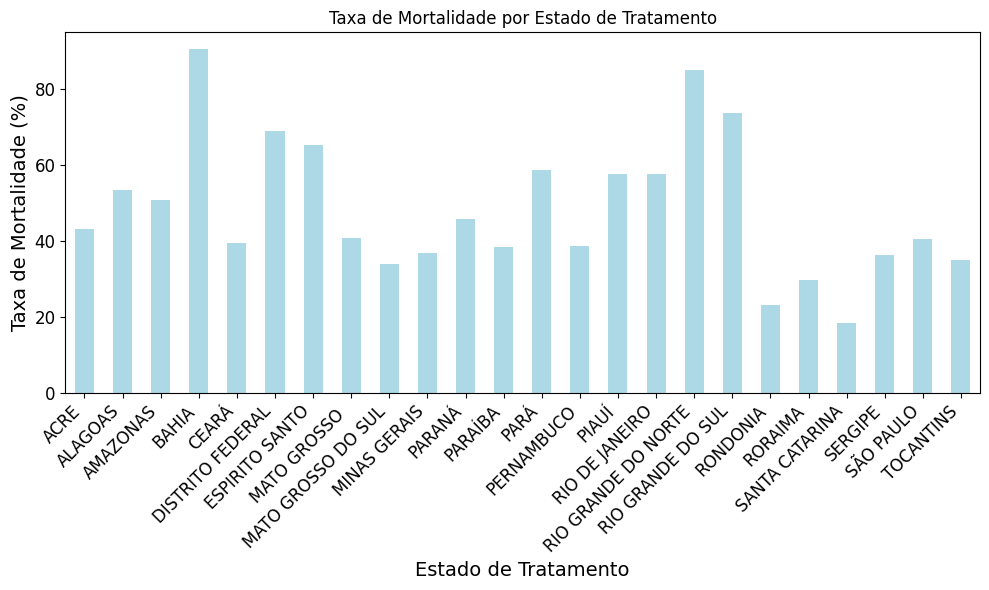

In [25]:
import matplotlib.pyplot as plt

taxa_mortalidade_estado.plot(kind='bar', figsize=(10, 6), color='lightblue')
plt.title('Taxa de Mortalidade por Estado de Tratamento')
plt.xlabel('Estado de Tratamento')
plt.ylabel('Taxa de Mortalidade (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Número de pacientes em cada Estado:

In [26]:
import pandas as pd

pacientes_por_estado = cancerdatacopy['Status.Address'].value_counts()

print("\nDistribuição dos Pacientes por Estado de Tratamento:")
print(pacientes_por_estado)


Distribuição dos Pacientes por Estado de Tratamento:
Status.Address
SÃO PAULO              55099
PARANÁ                 52731
MINAS GERAIS           48337
MATO GROSSO            43011
PARÁ                   34468
AMAZONAS               25675
PERNAMBUCO             25193
SANTA CATARINA         21944
ESPIRITO SANTO         21639
CEARÁ                  20143
DISTRITO FEDERAL       18325
RIO GRANDE DO SUL      17047
SERGIPE                14879
MATO GROSSO DO SUL     12100
ALAGOAS                 9653
PARAÍBA                 7852
PIAUÍ                   5323
RONDONIA                4683
RORAIMA                 3907
ACRE                    3594
TOCANTINS               3027
RIO DE JANEIRO          2021
BAHIA                    800
RIO GRANDE DO NORTE       87
Name: count, dtype: int64


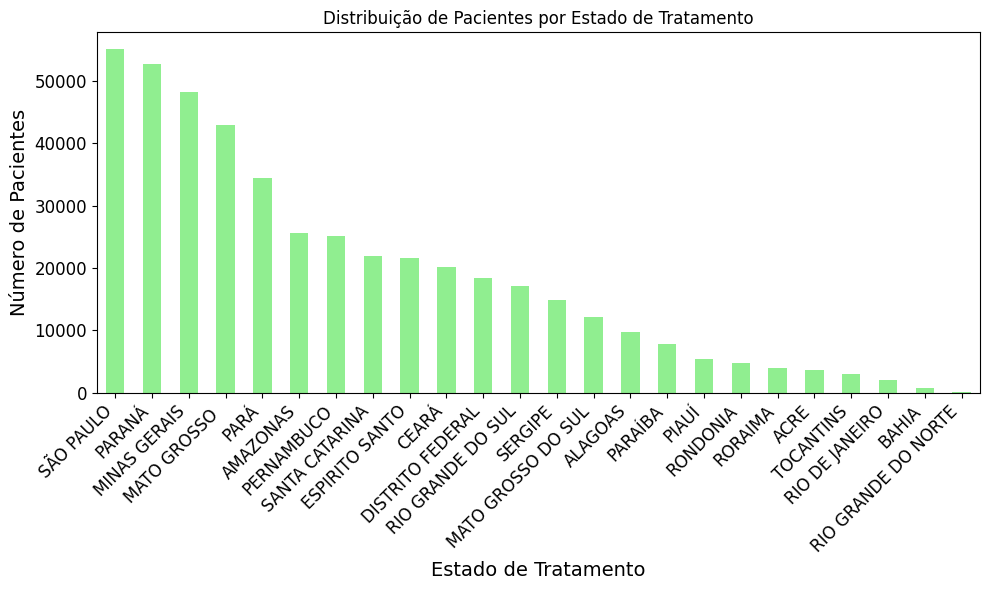

In [27]:
import matplotlib.pyplot as plt

pacientes_por_estado.plot(kind='bar', figsize=(10, 6), color='lightgreen')
plt.title('Distribuição de Pacientes por Estado de Tratamento')
plt.xlabel('Estado de Tratamento')
plt.ylabel('Número de Pacientes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Tempo de Tratamento em cada Estado:

In [28]:
import pandas as pd

cancerdatacopy['Data.Inicio'] = pd.to_datetime(cancerdatacopy['Date.of.Diagnostic'], errors='coerce')
cancerdatacopy['Data.Termino'] = pd.to_datetime(cancerdatacopy['Date.of.Last.Contact'], errors='coerce')

cancerdatacopy['Data.Termino'] = cancerdatacopy['Data.Termino'].fillna(pd.Timestamp.now())

cancerdatacopy['tempo_tratamento'] = (cancerdatacopy['Data.Termino'] - cancerdatacopy['Data.Inicio']).dt.days/365

tempo_tratamento_estado = cancerdatacopy.groupby('Status.Address')['tempo_tratamento'].mean()

print("\nTempo Médio de Tratamento por Estado de Tratamento:")
print(tempo_tratamento_estado)


Tempo Médio de Tratamento por Estado de Tratamento:
Status.Address
ACRE                    2.934485
ALAGOAS                 1.460783
AMAZONAS               16.013447
BAHIA                  19.990949
CEARÁ                  14.610439
DISTRITO FEDERAL       12.812156
ESPIRITO SANTO         16.292770
MATO GROSSO            12.084060
MATO GROSSO DO SUL     14.118380
MINAS GERAIS           13.889700
PARANÁ                  9.572923
PARAÍBA                12.206874
PARÁ                   14.299408
PERNAMBUCO             12.653852
PIAUÍ                  21.510886
RIO DE JANEIRO          8.636184
RIO GRANDE DO NORTE     5.443332
RIO GRANDE DO SUL      12.597943
RONDONIA                8.500493
RORAIMA                17.595880
SANTA CATARINA         12.252093
SERGIPE                12.777675
SÃO PAULO               7.929568
TOCANTINS              12.011016
Name: tempo_tratamento, dtype: float64


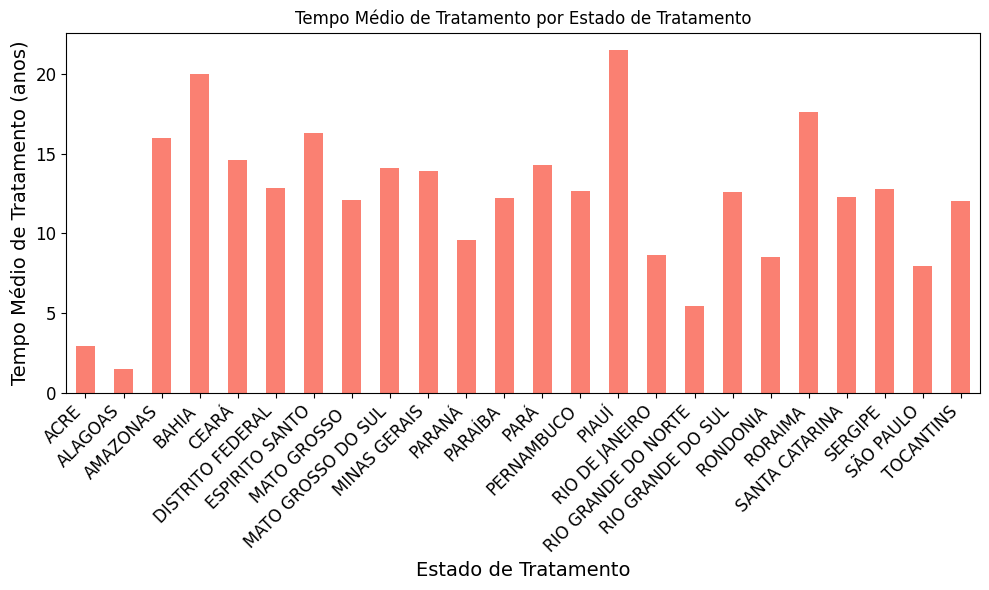

In [29]:
import matplotlib.pyplot as plt

tempo_tratamento_estado.plot(kind='bar', figsize=(10, 6), color='salmon')
plt.title('Tempo Médio de Tratamento por Estado de Tratamento')
plt.xlabel('Estado de Tratamento')
plt.ylabel('Tempo Médio de Tratamento (anos)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Pergunta 4 - Diferenças por centro de tratamento

Como cada centro de tratamento lida com seus pacientes?

Quais centros tem maior mortalidade?

E quais têm maior taxa de sobrevivência?

In [30]:
import pandas as pd

cancerdatacopy['Dead'] = cancerdatacopy['Date.of.Death'].notna()

centros_tratamento = cancerdatacopy.groupby('RCBP.Name')

mortes = centros_tratamento['Dead'].sum()
total_pacientes = centros_tratamento.size()

taxa_mortalidade = mortes / total_pacientes * 100
taxa_sobrevivencia = 100 - taxa_mortalidade

print("Taxa de Mortalidade por Centro de Tratamento:")
print(taxa_mortalidade.sort_values(ascending=False))

print("\nTaxa de Sobrevivência por Centro de Tratamento:")
print(taxa_sobrevivencia.sort_values(ascending=False))

Taxa de Mortalidade por Centro de Tratamento:
RCBP.Name
RCBP CAMPINAS-UNICAMP          92.281986
RCBP SALVADOR                  90.375000
RCBP NATAL                     85.057471
RCBP PORTO ALEGRE              73.526134
RCBP DISTRITO FEDERAL          69.004093
RCBP ESPÍRITO SANTO            65.298766
RCBP BELÉM                     58.695021
RCBP TERESINA                  57.467593
RCBP ANGRA DOS REIS            57.446809
RCBP SANTOS                    54.069466
RCBP ALAGOAS                   53.361649
RCBP MANAUS                    50.652386
RCBP CURITIBA                  45.614534
RCBP ACRE                      43.155259
RCBP MATO GROSSO (INTERIOR)    42.646586
RCBP DRS BARRETOS              41.833009
RCBP JAHU                      40.853744
RCBP FORTALEZA                 39.294048
RCBP RECIFE                    38.562299
RCBP JOAO PESSOA               38.423332
RCBP BELO HORIZONTE            38.257576
RCBP CUIABA                    36.871247
RCBP ARACAJU                   36.111298
R

Plotando a taxa de mortalidade por centro:

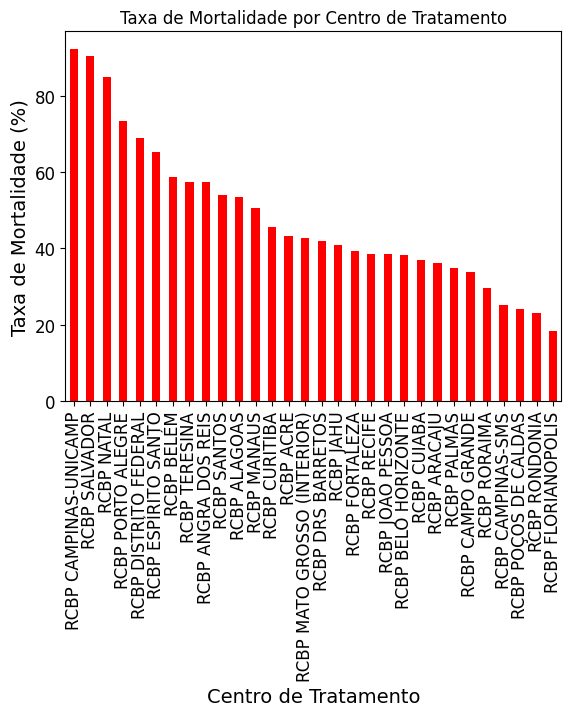

In [31]:
import matplotlib.pyplot as plt

taxa_mortalidade.sort_values(ascending=False).plot(kind='bar', color='red', label='Taxa de Mortalidade')
plt.title('Taxa de Mortalidade por Centro de Tratamento')
plt.xlabel('Centro de Tratamento')
plt.ylabel('Taxa de Mortalidade (%)')
plt.show()

Plotando a taxa de sobrevivência por centro:

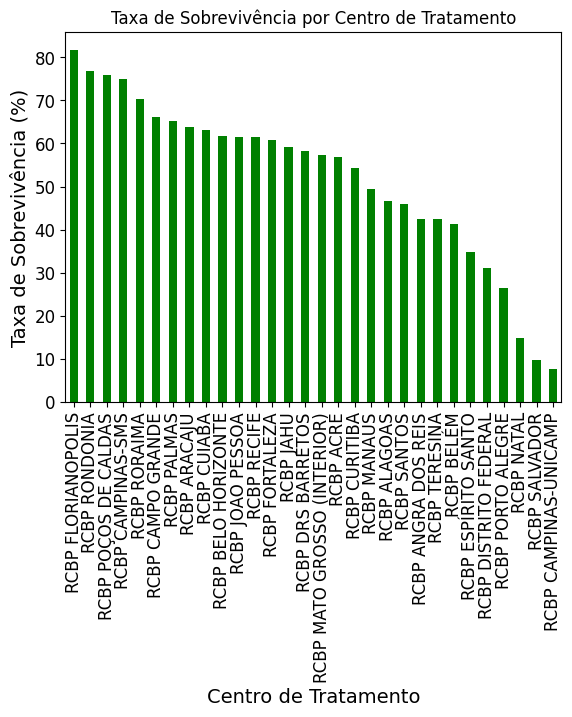

In [32]:
import matplotlib.pyplot as plt

taxa_sobrevivencia.sort_values(ascending=False).plot(kind='bar', color='green', label='Taxa de Sobrevivência')
plt.title('Taxa de Sobrevivência por Centro de Tratamento')
plt.xlabel('Centro de Tratamento')
plt.ylabel('Taxa de Sobrevivência (%)')
plt.show()

Descobrindo o tempo de tratamento por Centro:

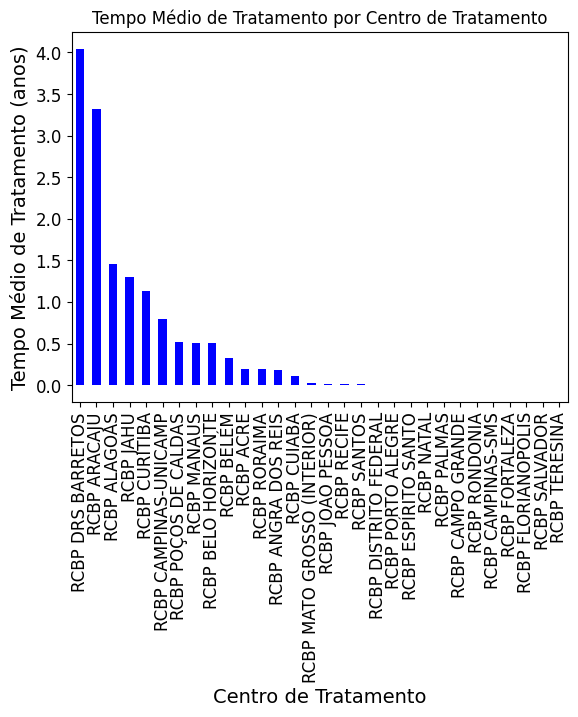

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

cancerdatacopy['Inicio.Tratamento'] = pd.to_datetime(cancerdatacopy['Date.of.Diagnostic'], errors='coerce')
cancerdatacopy['Fim.Tratamento'] = pd.to_datetime(cancerdatacopy['Date.of.Last.Contact'], errors='coerce')
cancerdatacopy['tempo_tratamento'] = (cancerdatacopy['Fim.Tratamento'] - cancerdatacopy['Inicio.Tratamento']).dt.days/365

tempo_medio_tratamento = centros_tratamento['tempo_tratamento'].mean()

tempo_medio_tratamento.sort_values(ascending=False).plot(kind='bar', color='blue')
plt.title('Tempo Médio de Tratamento por Centro de Tratamento')
plt.xlabel('Centro de Tratamento')
plt.ylabel('Tempo Médio de Tratamento (anos)')
plt.show()

Conseguimos também analisar a faixa etária de cada paciente, ver se esse fator influencia -ou não-, na taxa de sobrevivência da população com câncer em cada centro de tratamento.

Taxa de mortalidade por faixa etária:

<ipython-input-34-ee034f7f84ba>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  taxa_mortalidade_idade = cancerdatacopy.groupby('faixa_etaria')['Dead'].mean() * 100


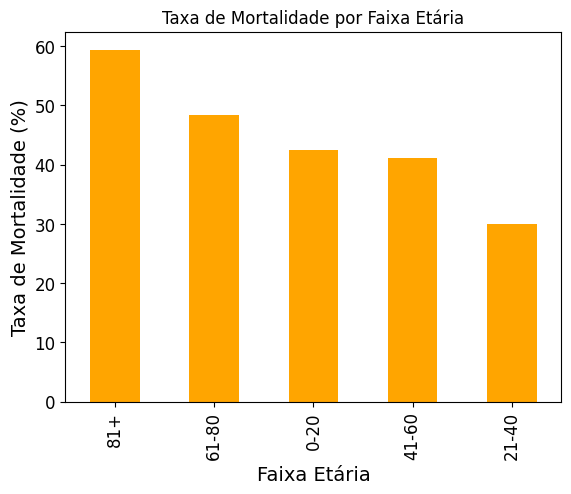

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '21-40', '41-60', '61-80', '81+']
cancerdatacopy['faixa_etaria'] = pd.cut(cancerdatacopy['Age'], bins=bins, labels=labels, right=False)

taxa_mortalidade_idade = cancerdatacopy.groupby('faixa_etaria')['Dead'].mean() * 100

taxa_mortalidade_idade.sort_values(ascending=False).plot(kind='bar', color='orange')
plt.title('Taxa de Mortalidade por Faixa Etária')
plt.xlabel('Faixa Etária')
plt.ylabel('Taxa de Mortalidade (%)')
plt.show()

Taxa de mortalidade por faixa etária por centro de tratamento:

<ipython-input-35-9c3eb9b417f5>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  taxa_mortalidade_idade_centro = cancerdatacopy.groupby(['RCBP.Name', 'faixa_etaria'])['Dead'].mean() * 100


Taxa de Mortalidade por Faixa Etária e Centro de Tratamento:
RCBP.Name      faixa_etaria
RCBP ACRE      0-20            31.250000
               21-40           34.979424
               41-60           39.396226
               61-80           47.461538
               81+             61.888112
                                 ...    
RCBP TERESINA  0-20            56.730769
               21-40           40.805604
               41-60           54.162162
               61-80           61.662075
               81+             70.137525
Name: Dead, Length: 150, dtype: float64


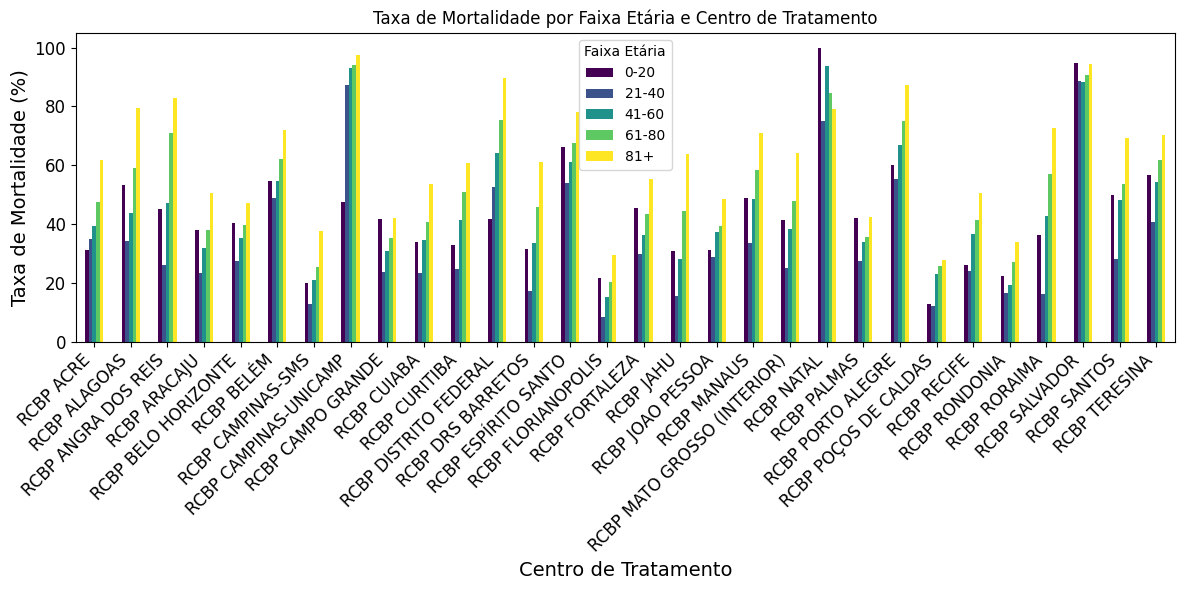

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '21-40', '41-60', '61-80', '81+']
cancerdatacopy['faixa_etaria'] = pd.cut(cancerdatacopy['Age'], bins=bins, labels=labels, right=False)

taxa_mortalidade_idade_centro = cancerdatacopy.groupby(['RCBP.Name', 'faixa_etaria'])['Dead'].mean() * 100

print("Taxa de Mortalidade por Faixa Etária e Centro de Tratamento:")
print(taxa_mortalidade_idade_centro)

taxa_mortalidade_idade_centro_unstacked = taxa_mortalidade_idade_centro.unstack(level='faixa_etaria')

taxa_mortalidade_idade_centro_unstacked.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title('Taxa de Mortalidade por Faixa Etária e Centro de Tratamento')
plt.xlabel('Centro de Tratamento')
plt.ylabel('Taxa de Mortalidade (%)')
plt.legend(title='Faixa Etária')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Pergunta 5 - Algumas pequenas análises...



Iremos fazer também uma breve análise da qualidade dos dados, observando algumas relações menores do nosso conjunto de dados **'cancerdata'**.


*   **Casos entre homens e mulheres:**



In [36]:
valores_nulos = cancerdata.isnull().sum().sort_values(ascending=False)

<ipython-input-37-cbe11643ac63>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=cancerdata, palette='deep')


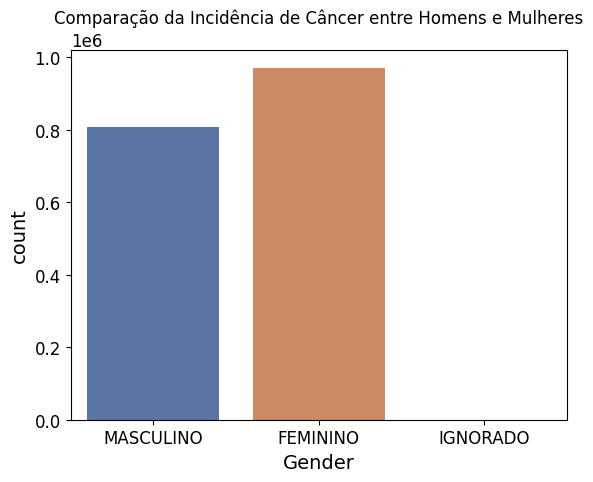

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Gender', data=cancerdata, palette='deep')

plt.title('Comparação da Incidência de Câncer entre Homens e Mulheres')
plt.show()

* **Casos mortais entre homens e mulheres:**

<ipython-input-38-d845a188f1f2>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=dead_patients, palette='deep')


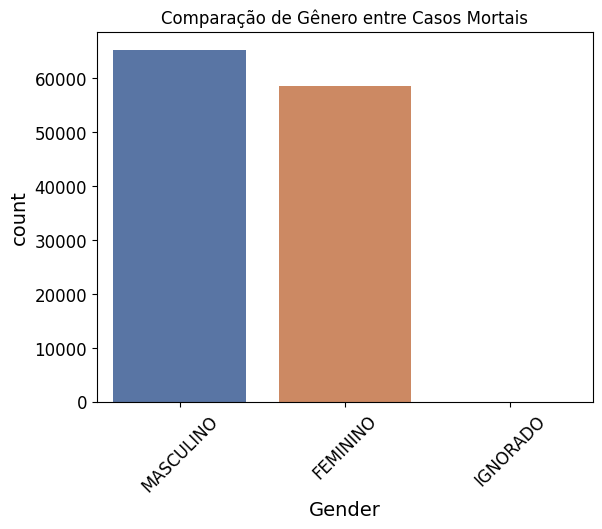

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dead_patients = cancerdata[cancerdata['Status.Vital'] == 'MORTO']

gender_death_counts = dead_patients.groupby('Gender').size()

sns.countplot(x='Gender', data=dead_patients, palette='deep')
plt.title('Comparação de Gênero entre Casos Mortais')
plt.xticks(rotation=45)
plt.show()

* **Comparação de casos por Raça/cor:**

<ipython-input-39-dc92199ef9e1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Raca.Color', data=cancerdata , palette='deep')


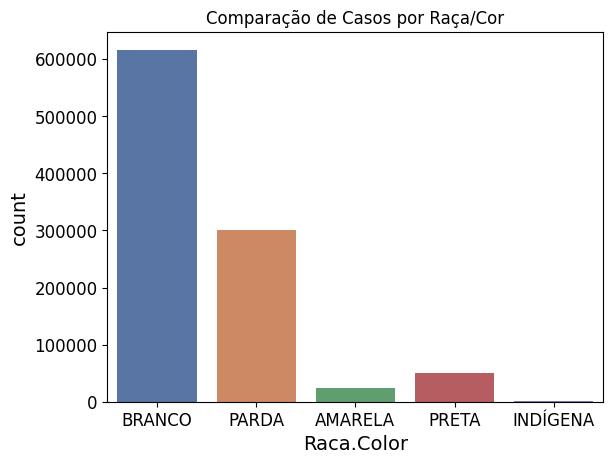

In [39]:
gender_counts = cancerdata.groupby('Raca.Color').size()

sns.countplot(x='Raca.Color', data=cancerdata , palette='deep')
plt.title('Comparação de Casos por Raça/Cor')
plt.show()

* **Relação de casos pelo método de descoberta da doença:**

<ipython-input-40-d92b07ecd123>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Diagnostic.means', data=cancerdata , palette='deep')


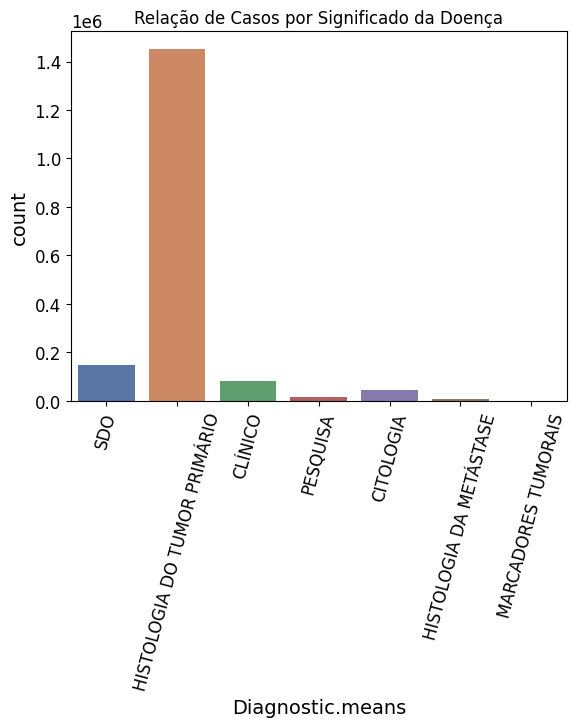

In [40]:
gender_counts = cancerdata.groupby('Diagnostic.means').size()

sns.countplot(x='Diagnostic.means', data=cancerdata , palette='deep')
plt.title('Relação de Casos por Descoberta da Doença')
plt.xticks(rotation=75)
plt.show()

* **Relação de casos por estado de nascimento:**

<ipython-input-41-76ac2bd834cc>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Naturality.State', data=filtered_data, palette='deep')


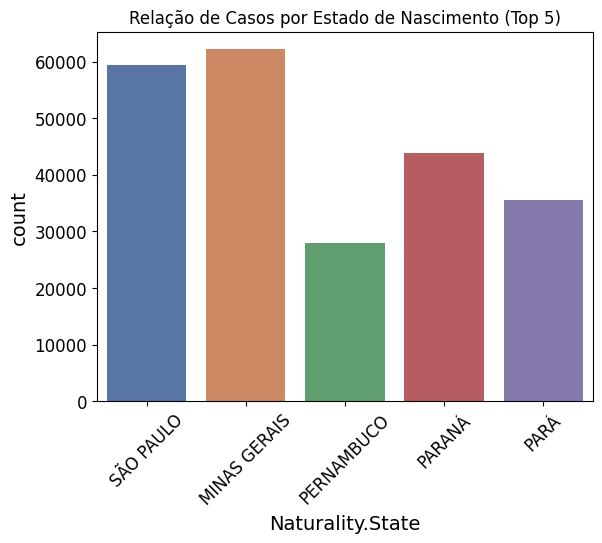

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

naturalitystate_counts = cancerdata.groupby('Naturality.State').size()

top_5_states = naturalitystate_counts.sort_values(ascending=False).head(5).index.tolist()

filtered_data = cancerdata[cancerdata['Naturality.State'].isin(top_5_states)]

sns.countplot(x='Naturality.State', data=filtered_data, palette='deep')
plt.title('Relação de Casos por Estado de Nascimento (Top 5)')
plt.xticks(rotation=45)
plt.show()

* **Relação de casos por ocupações profissionais:**

<ipython-input-42-305d0812d062>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Name.Occupation', data=filtered_data, palette='deep')
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


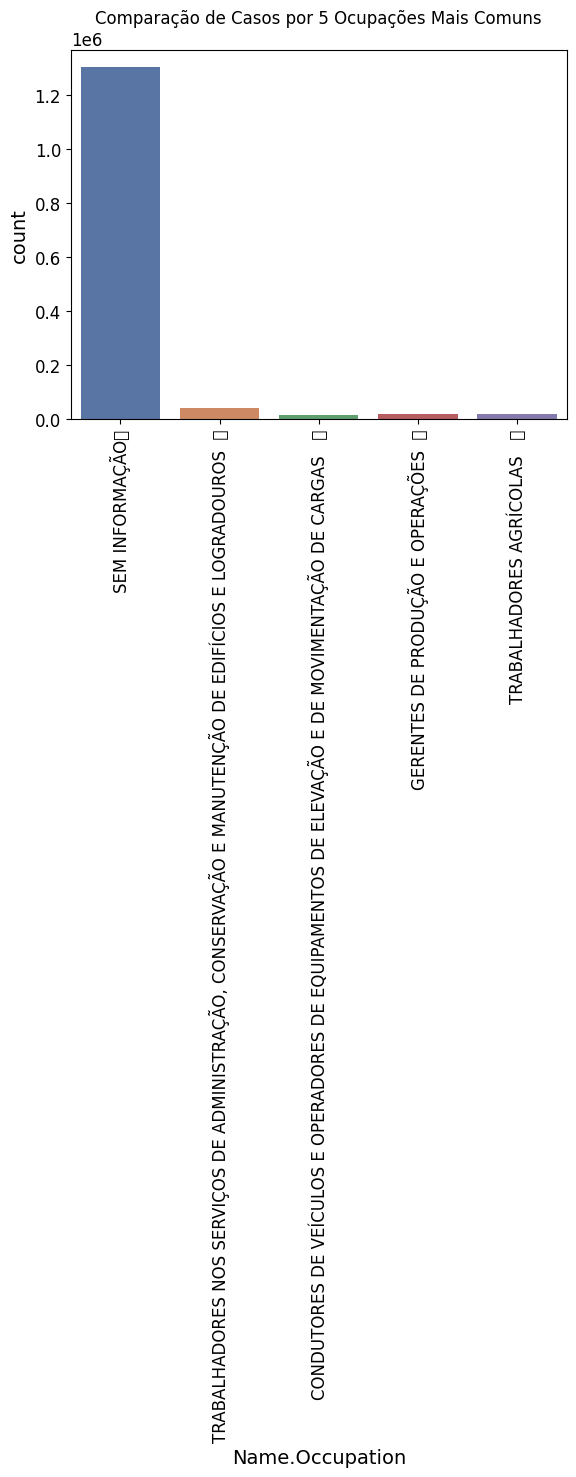

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

occupation_counts = cancerdata.groupby('Name.Occupation').size()

top_5_occupations = occupation_counts.sort_values(ascending=False).head(5).index.tolist()

filtered_data = cancerdata[cancerdata['Name.Occupation'].isin(top_5_occupations)]

sns.countplot(x='Name.Occupation', data=filtered_data, palette='deep')
plt.title('Comparação de Casos por 5 Ocupações Mais Comuns')
plt.xticks(rotation=90)
plt.show()

## Pergunta 6 - Cidades com população com maior incidência do câncer


Unindo os dois conjuntos de dados podemos fazer algumas análises interessantes. Podemos explorar algumas relações como:

*   **Distribuição de Diagnósticos por População:**
A relação entre o número de diagnósticos de câncer em uma cidade e a sua população ao longo dos anos.
*   **Taxa de Diagnóstico por População:**
A taxa de diagnóstico de câncer por população nas cidades. Isso ajuda a entender a concentração de diagnósticos em cidades com maior ou menor população.
* **Análise Temporal por Cidade:**
Como o número de diagnósticos de câncer mudou ao longo do tempo nas diferentes cidades, em relação ao crescimento populacional.

Primeiro, vamos obter a população de cada cidade no ano de diagnostico de cada paciente.

In [43]:
import pandas as pd

cidadepopulacao = municipioscopy[['ano','populacao','NOME']]

cancerdatacopy['City.Address'] = cancerdatacopy['City.Address'].str.upper()
cidadepopulacao['NOME'] = cidadepopulacao['NOME'].str.upper()

cancerdatacopy['year'] = cancerdatacopy['year'].fillna(0)
cancerdatacopy['year'] = cancerdatacopy['year'].astype(int)

dados_combinados = pd.merge(cancerdatacopy, cidadepopulacao, how='left',
                            left_on=['City.Address', 'year'],
                            right_on=['NOME', 'ano'])

print(dados_combinados.head())

<ipython-input-43-ca8a48bdd326>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cidadepopulacao['NOME'] = cidadepopulacao['NOME'].str.upper()


   Patient.Code              RCBP.Name     Gender Date.of.Birth   Age  \
0      672054.0  RCBP CAMPINAS-UNICAMP  MASCULINO    1975-03-16  30.0   
1      673396.0  RCBP CAMPINAS-UNICAMP   FEMININO    1951-09-02  51.0   
2      673745.0  RCBP CAMPINAS-UNICAMP  MASCULINO    1934-07-03  71.0   
3      676350.0  RCBP CAMPINAS-UNICAMP  MASCULINO    1933-11-18  71.0   
4      679877.0  RCBP CAMPINAS-UNICAMP   FEMININO    1947-11-30  57.0   

  Raca.Color Nationality Naturality.State Naturality Degree.of.Education  ...  \
0     BRANCO      BRASIL        SÃO PAULO        NaN                 NaN  ...   
1      PARDA      BRASIL        SÃO PAULO        NaN                 NaN  ...   
2     BRANCO      BRASIL        SÃO PAULO        NaN                 NaN  ...   
3     BRANCO      BRASIL        SÃO PAULO        NaN   SUPERIOR COMPLETO  ...   
4      PARDA      BRASIL          ALAGOAS        NaN                 NaN  ...   

   Dead  Data.Inicio Data.Termino tempo_tratamento Inicio.Tratamento  \
0 

**Calcular Taxa de Diagnóstico por População e sua distribuição de diagnóstico por População:**
Agora que temos os dados combinados, podemos calcular a taxa de diagnóstico por população para cada cidade e ano. A taxa de diagnóstico pode ser calculada da seguinte forma:

taxa de diagnóstico = [(numero de diagnosticos)/(população)]*1000

Essa fórmula nos dá o número de diagnósticos de câncer por 1.000 habitantes, o que facilita a comparação entre cidades de diferentes tamanhos populacionais.**negrito**

In [44]:
import pandas as pd

diagnosticos_por_populacao = dados_combinados.groupby(['NOME', 'year'])['Date.of.Diagnostic'].count()
diagnosticos_por_populacao = diagnosticos_por_populacao.reset_index(name='num_diagnosticos')

dados_combinados_completa = pd.merge(diagnosticos_por_populacao, cidadepopulacao, how='left',
                                     left_on=['NOME', 'year'],
                                     right_on=['NOME', 'ano'])

dados_combinados_completa['taxa_diagnostico'] = (dados_combinados_completa['num_diagnosticos'] / dados_combinados_completa['populacao']) * 1000

print(dados_combinados_completa.head())

       NOME  year  num_diagnosticos   ano  populacao  taxa_diagnostico
0  ACORIZAL  2003                 1  2003     5974.0          0.167392
1  ACORIZAL  2004                 2  2004     6078.0          0.329056
2  ACORIZAL  2006                15  2006     6193.0          2.422089
3  ACORIZAL  2007                 3  2007     5530.0          0.542495
4  ACORIZAL  2008                 4  2008     5679.0          0.704349


**Produzindo uma taxa de incidência de câncer por cidade:**
Somando todos os diagnósticos por cidade e tomando a população máxima da cidade em todos os anos vigentes, e então dividindo um pelo outro produzimos uma taxa de incidência de câncer por cidade.

In [45]:
diagnosticos_por_cidade = dados_combinados_completa.groupby('NOME').agg(
    num_diagnosticos=('num_diagnosticos', 'sum'),
    populacao=('populacao', 'max')
).reset_index()

print("\nRelação entre População e Número de Diagnósticos:")
print(diagnosticos_por_cidade)


Relação entre População e Número de Diagnósticos:
                      NOME  num_diagnosticos  populacao
0                 ACORIZAL               110     6193.0
1               ACRELÂNDIA                45    14120.0
2           AFONSO CLÁUDIO               147    31384.0
3            ALTA FLORESTA               656    51414.0
4    ALTA FLORESTA D'OESTE                46    25578.0
..                     ...               ...        ...
443                 VIÇOSA               549    72786.0
444          VÁRZEA GRANDE             15656   271339.0
445                 XAPURI                40    17608.0
446               ÁGUA BOA               912    24032.0
447            ÁGUA BRANCA               549    19433.0

[448 rows x 3 columns]


In [46]:
diagnosticos_por_cidade['taxa_incidencia'] = diagnosticos_por_cidade['num_diagnosticos'] / diagnosticos_por_cidade['populacao']

print("\nTaxa de Incidência de Câncer por Cidade:")
print(diagnosticos_por_cidade[['NOME', 'taxa_incidencia']])


Taxa de Incidência de Câncer por Cidade:
                      NOME  taxa_incidencia
0                 ACORIZAL         0.017762
1               ACRELÂNDIA         0.003187
2           AFONSO CLÁUDIO         0.004684
3            ALTA FLORESTA         0.012759
4    ALTA FLORESTA D'OESTE         0.001798
..                     ...              ...
443                 VIÇOSA         0.007543
444          VÁRZEA GRANDE         0.057699
445                 XAPURI         0.002272
446               ÁGUA BOA         0.037949
447            ÁGUA BRANCA         0.028251

[448 rows x 2 columns]


**Observando as cidades com a maior e menor incidência de câncer:**

In [47]:
maior_taxa = diagnosticos_por_cidade.sort_values(by='taxa_incidencia', ascending=False).head(1)
menor_taxa = diagnosticos_por_cidade.sort_values(by='taxa_incidencia', ascending=True).head(1)

print("\nCidade com maior taxa de incidência de câncer:")
print(maior_taxa)

print("\nCidade com menor taxa de incidência de câncer:")
print(menor_taxa)


Cidade com maior taxa de incidência de câncer:
     NOME  num_diagnosticos  populacao  taxa_incidencia
45  BELÉM            255825  1452275.0         0.176155

Cidade com menor taxa de incidência de câncer:
      NOME  num_diagnosticos  populacao  taxa_incidencia
237  NATAL                87   798065.0         0.000109


**Variação da taxa de incidência de câncer total ao longo dos anos:**

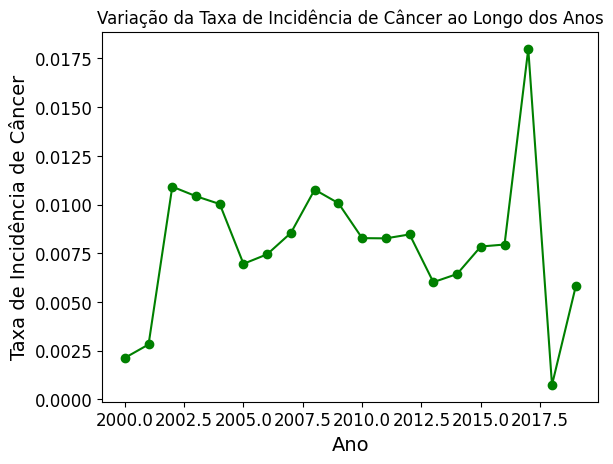

In [48]:
dados_combinados_completa['taxa_incidencia'] = dados_combinados_completa['num_diagnosticos'] / dados_combinados_completa['populacao']
taxa_incidencia_ano = dados_combinados_completa.groupby('year')['taxa_incidencia'].mean()

taxa_incidencia_ano.plot(kind='line', marker='o', color='green')
plt.title('Variação da Taxa de Incidência de Câncer ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Taxa de Incidência de Câncer')
plt.show()

**Análise Temporal por Cidade:**
Como o número de diagnósticos de câncer mudou ao longo do tempo nas diferentes cidades, em relação ao crescimento populacional.

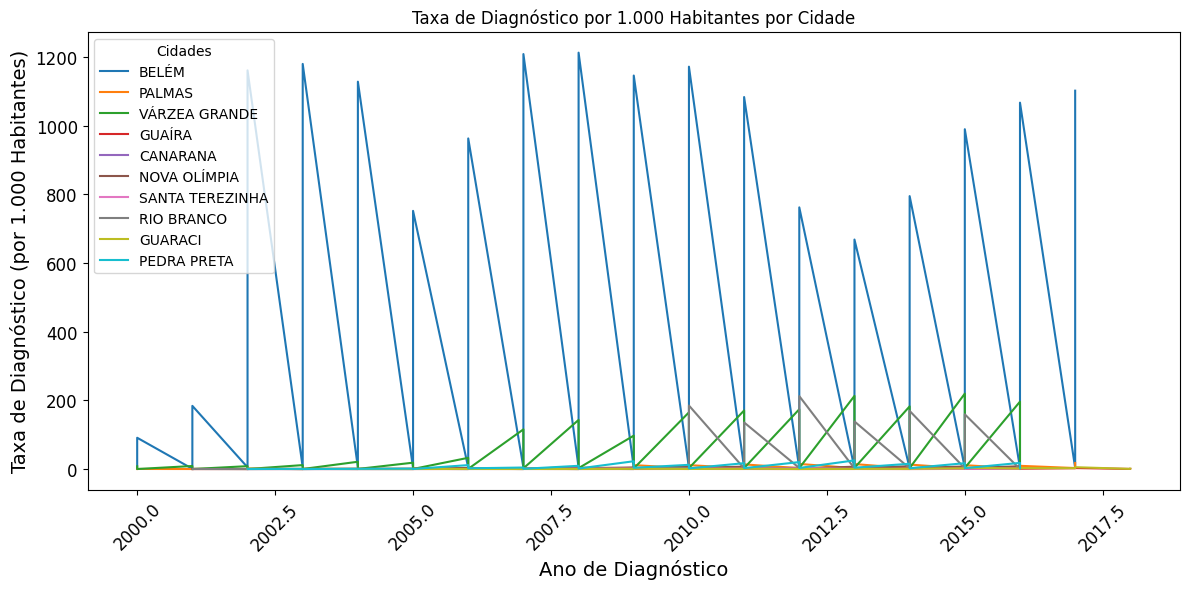

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

cidades_selecionadas = dados_combinados_completa['NOME'].value_counts().head(10).index
dados_filtrados = dados_combinados_completa[dados_combinados_completa['NOME'].isin(cidades_selecionadas)]

for cidade in cidades_selecionadas:
    cidade_dados = dados_filtrados[dados_filtrados['NOME'] == cidade]
    plt.plot(cidade_dados['year'], cidade_dados['taxa_diagnostico'], label=cidade)

plt.title('Taxa de Diagnóstico por 1.000 Habitantes por Cidade')
plt.xlabel('Ano de Diagnóstico')
plt.ylabel('Taxa de Diagnóstico (por 1.000 Habitantes)')
plt.legend(title='Cidades')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Separando os Dados

Se quisermos utilizar um conjunto de teste para realizar uma estimativa "não enviesada" do modelo final é importante já separarmos o conjunto de treino e teste desde já.

Observa que a função train_test_split implentada no scikit-learn tem como padrão shuffle = True. Isto quer dizer que ele irá embaralhar os dados e então fara a divisão do conjunto de dados em treino e teste.

É importante que os dados sejam embaralhados pois é comum que exista algum tipo de ordenação nos dados, de forma que se você não embaralhar os dados estará introduzindo tendencias ou vieses que não existem nos dados reais.

In [50]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(cancerdata,
                                       test_size=0.2,
                                       random_state=seed)

Essa divisão no conjunto de dados é até então puramente aleatória. Será que esse tipo de divisão é a mais indicada?

Vejamos novamente as medidas resumo da renda mediana:

In [51]:
cancerdata["City.Address"].describe()

,City.Address
count,1714334
unique,470
top,SÃO PAULO
freq,656882


In [52]:
municipios['NOME'].describe()

,NOME
count,168818
unique,5297
top,Bom Jesus
freq,150


2. Iremos fazer um merge de dados de forma a relacionar as tabelas **'cancerdata'** e **'municipios'** em uma tabela menor, que contenha informações importantes das duas ao mesmo tempo.


* Merge dos dados:

In [53]:
cancerdata['City.Address'] = cancerdata['City.Address'].str.upper()
municipios['NOME'] = municipios['NOME'].str.upper()

cancerdata['year'] = cancerdata['year'].fillna(0)
cancerdata['year'] = cancerdata['year'].astype(int)

cidadepopulacao = municipios[['ano', 'populacao', 'NOME']]

dados_combinados = pd.merge(cancerdata, cidadepopulacao, how='left',
                            left_on=['City.Address', 'year'],
                            right_on=['NOME', 'ano'])

print(dados_combinados.head())


   Patient.Code              RCBP.Name     Gender Date.of.Birth   Age  \
0      672054.0  RCBP CAMPINAS-UNICAMP  MASCULINO    1975-03-16  30.0   
1      673213.0  RCBP CAMPINAS-UNICAMP   FEMININO    1950-05-24  53.0   
2      673396.0  RCBP CAMPINAS-UNICAMP   FEMININO    1951-09-02  51.0   
3      673425.0  RCBP CAMPINAS-UNICAMP   FEMININO    1929-11-21  73.0   
4      673745.0  RCBP CAMPINAS-UNICAMP  MASCULINO    1934-07-03  71.0   

  Raca.Color Nationality Naturality.State Naturality Degree.of.Education  ...  \
0     BRANCO      BRASIL        SÃO PAULO        NaN                 NaN  ...   
1        NaN         NaN              NaN        NaN                 NaN  ...   
2      PARDA      BRASIL        SÃO PAULO        NaN                 NaN  ...   
3        NaN         NaN              NaN        NaN                 NaN  ...   
4     BRANCO      BRASIL        SÃO PAULO        NaN                 NaN  ...   

  Type.of.Death  Date.of.Death Date.of.Last.Contact Date.of.Diagnostic  \


Utilizar tabela com menos informações para o treinamento.

In [54]:
import pandas as pd

diagnosticos_por_populacao = dados_combinados.groupby(['NOME', 'year'])['Date.of.Diagnostic'].count()
diagnosticos_por_populacao = diagnosticos_por_populacao.reset_index(name='num_diagnosticos')

dados_combinados_completa = pd.merge(diagnosticos_por_populacao, cidadepopulacao, how='left',
                                     left_on=['NOME', 'year'],
                                     right_on=['NOME', 'ano'])

dados_combinados_completa['taxa_diagnostico'] = (dados_combinados_completa['num_diagnosticos'] / dados_combinados_completa['populacao']) * 1000

print(dados_combinados_completa.shape)

print(dados_combinados_completa.head())

(5102, 6)
       NOME  year  num_diagnosticos   ano  populacao  taxa_diagnostico
0  ACORIZAL  2001                 3  2001     5860.0          0.511945
1  ACORIZAL  2002                 4  2002     5924.0          0.675219
2  ACORIZAL  2003                 7  2003     5974.0          1.171744
3  ACORIZAL  2004                 6  2004     6078.0          0.987167
4  ACORIZAL  2005                 8  2005     6136.0          1.303781


Calculando algumas relações da coluna **target**.

In [55]:
mean = np.mean(dados_combinados_completa["num_diagnosticos"])
std = np.std(dados_combinados_completa["num_diagnosticos"])

print("Média:", mean)
print("Desvio Padrão:", std)

Média: 444.0248921991376
Desvio Padrão: 2620.0227843290754


<Axes: >

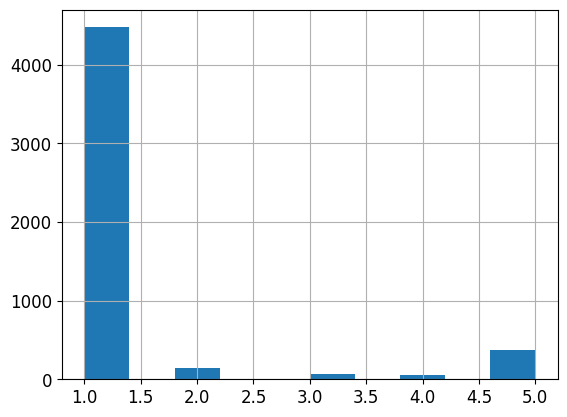

In [56]:
dados_combinados_completa["diagnosticos_cat"] = pd.cut(dados_combinados_completa["num_diagnosticos"],
                               bins=[0., 200., 400., 600., 800., np.inf],
                               labels=[1, 2, 3, 4, 5])

dados_combinados_completa["diagnosticos_cat"].hist()

In [57]:
dados_combinados_completa["diagnosticos_cat"].value_counts()

,count
diagnosticos_cat,
1,4474
5,367
2,139
3,63
4,59


Amostragem Estratificada
* Com base em uma feature importante para o modelo (ex.: diagnosticos_cat):

In [58]:
print(dados_combinados_completa['diagnosticos_cat'].isnull().sum())
print(dados_combinados_completa.shape)

0
(5102, 7)


In [59]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, test_index in split.split(dados_combinados_completa, dados_combinados_completa["diagnosticos_cat"]):
    strat_train_set = dados_combinados_completa.loc[train_index]
    strat_test_set = dados_combinados_completa.loc[test_index]

Acabamos de criar novos conjuntos de treino e de teste, que chamamos de strat_train_set e strat_test_set.

Estes conjuntos devem respeitar a estratificação que introduzimos baseada em "num_diagnoticos" representado na nova variável categórica "diagnosticos_cat".

Vejamos se funcionou:

In [60]:
strat_test_set["diagnosticos_cat"].value_counts() / len(strat_test_set)

dados_combinados_completa["diagnosticos_cat"].value_counts() / len(dados_combinados_completa)

,count
diagnosticos_cat,
1,0.876911
5,0.071933
2,0.027244
3,0.012348
4,0.011564


Podemos agora comparar com a amostragem aleatória :

In [61]:
def diagnosticos_cat_proportions(data):
    return data["diagnosticos_cat"].value_counts() / len(data)

Agora vamos gerar novamente conjunto de teste e treino, mas usando amostragem aleatória.

In [62]:
train_set, test_set = train_test_split(dados_combinados_completa, test_size=0.2, random_state=seed)

Vamos criar o nosso novo dataframe e visualizar os resultados:

In [63]:
compare_props = pd.DataFrame({
    "Geral": diagnosticos_cat_proportions(dados_combinados_completa),
    "Estratificado": diagnosticos_cat_proportions(strat_test_set),
    "Aleatorio": diagnosticos_cat_proportions(test_set),
}).sort_index()

compare_props["Aleatório %erro"] = 100 * compare_props["Aleatorio"] / compare_props["Geral"] - 100
compare_props["Estratificado %erro"] = 100 * compare_props["Estratificado"] / compare_props["Geral"] - 100

compare_props

,Geral,Estratificado,Aleatorio,Aleatório %erro,Estratificado %erro
diagnosticos_cat,,,,,
1,0.876911,0.876592,0.864838,-1.376721,-0.036428
2,0.027244,0.027424,0.025465,-6.529781,0.660236
3,0.012348,0.012733,0.016650,34.841348,3.113972
4,0.011564,0.011753,0.011753,1.635153,1.635153
5,0.071933,0.071499,0.081293,13.012567,-0.603405


Contentes com os resultados, não podemos esquecer de remover o atributo "diagnosticos_cat" dos conjuntos strat_train_set e strat_test_set. Na verdade, ele era apenas um intermediário, afinal de contas as informações dessa caracaterísticas já estão presentes em "num_diagnosticos".

In [64]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("diagnosticos_cat", axis=1, inplace=True)

# Visualização da Estrutura de Dados

Vamos agora visualizar os nossos dados. Precisamos ter certeza que não vamos visualizar dados do conjunto de teste, para evitar enviesamento de conclusões.

De um ponto de vista mais técnico, devemos evitar o **snooping bias**.

In [65]:
dados_combinados_completa = strat_train_set.copy()

Podemos criar uma matriz de correlação dos nossos dados

In [66]:
matriz_correlacao = dados_combinados_completa[['num_diagnosticos', 'populacao', 'taxa_diagnostico']].corr()
print(matriz_correlacao)

                  num_diagnosticos  populacao  taxa_diagnostico
num_diagnosticos          1.000000   0.924221          0.235663
populacao                 0.924221   1.000000         -0.014137
taxa_diagnostico          0.235663  -0.014137          1.000000


<Axes: xlabel='num_diagnosticos', ylabel='populacao'>

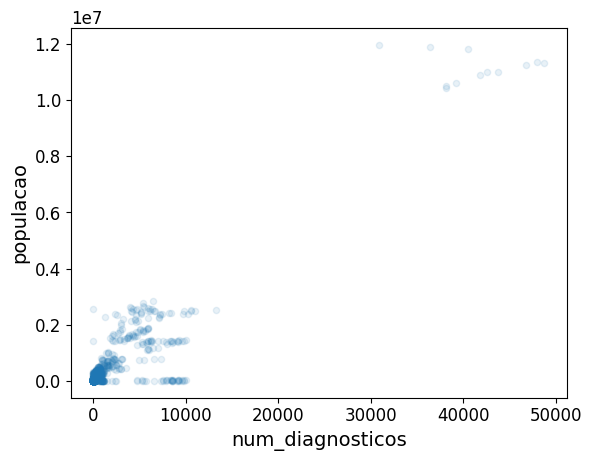

In [67]:
dados_combinados_completa.plot(kind="scatter", x="num_diagnosticos", y="populacao",
             alpha=0.1)

Através dessa plotagem conseguimos observar uma relação entre a população e o número de diagnósticos de câncer.

# Preparar os dados para o algoritmo de **Machine Learning**

**OBS:** Ao longo desta seção estaremos chamando as features de treinamento como "dados_combinados_completa". Atenção neste ponto para não confundir com o dataset inteiro. Isto é, tudo o que nos faremos aqui será feito somento no conjunto de treinamento!

A partir de agora vamos partir para etapa de limpeza de dados!

Vamos começar verificando se temos dados falantes:

In [68]:
sample_incomplete_rows = dados_combinados_completa[dados_combinados_completa.isnull().any(axis=1)].head()
sample_incomplete_rows

,NOME,year,num_diagnosticos,ano,populacao,taxa_diagnostico


Como pode ver, os dados já estão limpos, então podemos prossegir para treinar os modelos:

# Regressão Linear:

O modelo abaixo faz:

*  A Codificação das variáveis categóricas, utiliza o TimeSeriesSplit para evitar snooping bias, garantindo que o modelo seja treinado com dados anteriores e testado em dados futuros.

* Realiza a Regressão Linear: O modelo de regressão linear é treinado e avaliado nas divisões de treino e teste.

* Fornece Métricas de Avaliação: Calculamos e armazenamos as métricas MSE, RMSE, MAE e R² para cada divisão de treino/teste e depois tiramos a média de todas.

Dessa forma, a abordagem ajuda a validar o modelo sem fazer uso indevido dos dados futuros, preservando a integridade da previsão ao longo do tempo.

In [69]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

X = dados_combinados_completa[['year', 'populacao', 'NOME']]

y = dados_combinados_completa['num_diagnosticos']

X = pd.get_dummies(X, columns=['NOME'], drop_first=True)

tscv = TimeSeriesSplit(n_splits=5)

model = LinearRegression()

mse_list = []
rmse_list = []
mae_list = []
r2_list = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

print(f'MSE: {np.mean(mse_list):.4f}')
print(f'RMSE: {np.mean(rmse_list):.4f}')
print(f'MAE: {np.mean(mae_list):.4f}')
print(f'R2: {np.mean(r2_list):.4f}')


MSE: 1495630093953345536.0000
RMSE: 771678978.8135
MAE: 74157439.1270
R2: -171461998069.8428


# Random Forest:

O modelo abaixo faz:

* **Codificação das variáveis categóricas:** As variáveis categóricas são codificadas de forma apropriada para que possam ser utilizadas pelo modelo de Random Forest.

* **Utiliza o TimeSeriesSplit para evitar o snooping bias:** O TimeSeriesSplit é utilizado para garantir que o modelo seja treinado com dados anteriores e testado em dados futuros, prevenindo o vazamento de informações e garantindo uma avaliação robusta do modelo.

* **Realiza a classificação ou regressão com Random Forest:** O modelo de Random Forest é treinado e avaliado nas divisões de treino e teste, permitindo uma análise da performance do modelo em diferentes divisões temporais.

* **Fornece Métricas de Avaliação:** Calculamos e armazenamos as métricas como MSE, RMSE, MAE e R² para cada divisão de treino/teste e depois tiramos a média de todas, avaliando o desempenho preditivo do modelo.

Dessa forma, a abordagem ajuda a validar o modelo de Random Forest sem fazer uso indevido dos dados futuros, preservando a integridade da previsão ao longo do tempo.

In [70]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

X = dados_combinados_completa[['year', 'populacao', 'NOME']]

y = dados_combinados_completa['num_diagnosticos']

X = pd.get_dummies(X, columns=['NOME'], drop_first=True)

tscv = TimeSeriesSplit(n_splits=5)

model = RandomForestRegressor(n_estimators=100, random_state=42)

mse_list = []
rmse_list = []
mae_list = []
r2_list = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

print(f'MSE: {np.mean(mse_list):.4f}')
print(f'RMSE: {np.mean(rmse_list):.4f}')
print(f'MAE: {np.mean(mae_list):.4f}')
print(f'R2: {np.mean(r2_list):.4f}')


MSE: 146013.9477
RMSE: 331.3963
MAE: 73.0726
R2: 0.9793


# Decision Tree:

O modelo abaixo faz:

* **Codificação das variáveis categóricas:** As variáveis categóricas são codificadas de forma apropriada para que possam ser utilizadas pelo modelo de Decision Tree.

* **Utiliza o TimeSeriesSplit para evitar o snooping bias:** O TimeSeriesSplit é utilizado para garantir que o modelo seja treinado com dados anteriores e testado em dados futuros, prevenindo o vazamento de informações e garantindo uma avaliação robusta do modelo.

* **Realiza a classificação ou regressão com Decision Tree:** O modelo de Decision Tree é treinado e avaliado nas divisões de treino e teste, permitindo uma análise da performance do modelo em diferentes divisões temporais.

* **Fornece Métricas de Avaliação:** Calculamos e armazenamos as métricas como MSE, RMSE, MAE e R² para cada divisão de treino/teste e depois tiramos a média de todas, avaliando o desempenho preditivo do modelo.

Dessa forma, a abordagem ajuda a validar o modelo de Decision Tree sem fazer uso indevido dos dados futuros, preservando a integridade da previsão ao longo do tempo

In [71]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

X = dados_combinados_completa[['year', 'populacao', 'NOME']]

y = dados_combinados_completa['num_diagnosticos']

X = pd.get_dummies(X, columns=['NOME'], drop_first=True)

tscv = TimeSeriesSplit(n_splits=5)

model = DecisionTreeRegressor(random_state=42)

mse_list = []
rmse_list = []
mae_list = []
r2_list = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

print(f'MSE: {np.mean(mse_list):.4f}')
print(f'RMSE: {np.mean(rmse_list):.4f}')
print(f'MAE: {np.mean(mae_list):.4f}')
print(f'R2: {np.mean(r2_list):.4f}')


MSE: 280433.8491
RMSE: 468.1897
MAE: 86.1285
R2: 0.9630


# Justificativa da escolha das métricas

A previsão de preços de imóveis é um problema de regressão, portanto, utilizamos métricas de erro para avaliar a performance do modelo.

- **MSE (Mean Squared Error - Erro Quadrático Médio):** Calcula a média dos erros ao quadrado. É vantajoso porque penaliza erros maiores de maneira mais intensa, ajudando a evitar discrepâncias significativas nas previsões.
- **RMSE (Root Mean Squared Error - Raiz do Erro Quadrático Médio):** Corresponde à raiz quadrada do MSE, trazendo o erro para a mesma unidade dos dados originais, o que facilita a interpretação.
- **MAE (Mean Absolute Error - Erro Absoluto Médio):** Mede a média das diferenças absolutas entre os valores reais e os previstos. Essa métrica é resistente a outliers, pois não os penaliza de forma tão severa quanto o MSE.
- **R² (Coeficiente de Determinação):** Representa a proporção da variação dos preços explicada pelo modelo. Quanto mais próximo de 1, melhor o ajuste do modelo aos dados.

 O **MSE** e o **RMSE** são úteis para capturar a precisão das previsões, penalizando erros maiores, o que é fundamental, considerando que grandes variações nos preços das casas podem impactar significativamente decisões de compra e venda. Já o **R²** indica a capacidade do modelo em explicar a variação dos preços, refletindo o nível de ajuste aos dados. O **MAE** será utilizado apenas como uma métrica complementar.


# Buscando os melhores parâmetros:

Procura qual o melhor modelo através de uma validação cruzada.

In [72]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

X = dados_combinados_completa[['year', 'populacao', 'NOME']]

y = dados_combinados_completa['num_diagnosticos']

X = pd.get_dummies(X, columns=['NOME'], drop_first=True)

tscv = TimeSeriesSplit(n_splits=5)

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2', None]
}

param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_lr = {
    'fit_intercept': [True, False]
}

rf_model = RandomForestRegressor(random_state=42)
dt_model = DecisionTreeRegressor(random_state=42)
lr_model = LinearRegression()

def tune_and_evaluate(model, param_grid, X, y):
    grid = GridSearchCV(estimator=model,
                        param_grid=param_grid,
                        cv=tscv,
                        scoring='neg_mean_squared_error')
    grid.fit(X, y)

    best_estimator = grid.best_estimator_
    best_score = -grid.best_score_

    return best_estimator, best_score

best_rf_estimator, best_rf_score = tune_and_evaluate(rf_model, param_grid_rf, X, y)
print('Modelo: RandomForest')
print(f'Melhor Score (MSE): {best_rf_score}')
print(f'Melhores Parâmetros: {best_rf_estimator}')

best_dt_estimator, best_dt_score = tune_and_evaluate(dt_model, param_grid_dt, X, y)
print('\nModelo: Decision Tree')
print(f'Melhor Score (MSE): {best_dt_score}')
print(f'Melhores Parâmetros: {best_dt_estimator}')

best_lr_estimator, best_lr_score = tune_and_evaluate(lr_model, param_grid_lr, X, y)
print('\nModelo: Linear Regression')
print(f'Melhor Score (MSE): {best_lr_score}')
print(f'Melhores Parâmetros: {best_lr_estimator}')


Modelo: RandomForest
Melhor Score (MSE): 129221.47287882355
Melhores Parâmetros: RandomForestRegressor(max_features='sqrt', n_estimators=50, random_state=42)

Modelo: Decision Tree
Melhor Score (MSE): 250168.1272019324
Melhores Parâmetros: DecisionTreeRegressor(max_depth=20, random_state=42)

Modelo: Linear Regression
Melhor Score (MSE): 4.181885197879057e+17
Melhores Parâmetros: LinearRegression(fit_intercept=False)


# Modelo e Teste Final:

Verifica se o resultado obtido na validação cruzada se mantém.

In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

def evaluate_model_on_full_data(best_model, X, y):
    y_pred = best_model.predict(X)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, rmse, mae, r2

print('\nTeste Final: RandomForest')
mse_rf, rmse_rf, mae_rf, r2_rf = evaluate_model_on_full_data(best_rf_estimator, X, y)
print(f'MSE: {mse_rf:.4f}, RMSE: {rmse_rf:.4f}, MAE: {mae_rf:.4f}, R2: {r2_rf:.4f}')

print('\nTeste Final: DecisionTree')
mse_dt, rmse_dt, mae_dt, r2_dt = evaluate_model_on_full_data(best_dt_estimator, X, y)
print(f'MSE: {mse_dt:.4f}, RMSE: {rmse_dt:.4f}, MAE: {mae_dt:.4f}, R2: {r2_dt:.4f}')

print('\nTeste Final: LinearRegression')
mse_lr, rmse_lr, mae_lr, r2_lr = evaluate_model_on_full_data(best_lr_estimator, X, y)
print(f'MSE: {mse_lr:.4f}, RMSE: {rmse_lr:.4f}, MAE: {mae_lr:.4f}, R2: {r2_lr:.4f}')



Teste Final: RandomForest
MSE: 7945.2553, RMSE: 89.1362, MAE: 16.7526, R2: 0.9988

Teste Final: DecisionTree
MSE: 289.5890, RMSE: 17.0173, MAE: 9.8945, R2: 1.0000

Teste Final: LinearRegression
MSE: 169028.3213, RMSE: 411.1305, MAE: 79.0099, R2: 0.9746


# Conclusões:

A análise dos resultados dos três modelos (RandomForest, DecisionTree e LinearRegression) demonstra variações significativas em termos de desempenho na previsão do número de diagnósticos.

- **RandomForest** obteve um excelente desempenho com um **MSE de 7945.26**, um **RMSE de 89.14**, **MAE de 16.75** e **R2 de 0.9988**, indicando que o modelo se ajusta bem aos dados e faz previsões muito precisas, mas não tão perfeitas quanto o DecisionTree.

- **DecisionTree** teve o melhor desempenho geral, com um **MSE de 289.59**, **RMSE de 17.02**, **MAE de 9.89** e um **R2 perfeito de 1.0000**. Esse modelo apresentou o menor erro e a melhor capacidade de previsão, indicando um ajuste perfeito aos dados, embora possa ser propenso a overfitting.

- **LinearRegression**, por outro lado, apresentou um desempenho significativamente inferior com **MSE de 169028.32**, **RMSE de 411.13**, **MAE de 79.01** e **R2 de 0.9746**, sugerindo que o modelo linear não capturou adequadamente a complexidade dos dados, resultando em previsões menos precisas.

Em resumo, o **DecisionTree** demonstrou ser o modelo mais eficaz para esta tarefa específica, com o melhor desempenho em termos de erro e capacidade de ajuste aos dados, seguido pelo **RandomForest**. O **LinearRegression** não foi tão eficiente, evidenciando a necessidade de modelos mais complexos para este tipo de previsão.

# Curiosidade: Impressão dos Resultados

Utiliza a regressão linear de forma a tentar prever o número de diagnósticos dos próximos 10 anos!

In [84]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

ano_mais_recente = dados_combinados_completa['year'].max()
anos_futuros = np.arange(ano_mais_recente + 1, ano_mais_recente + 11)

previsoes_df = pd.DataFrame()

X = dados_combinados_completa[['year', 'populacao']]
y = dados_combinados_completa['num_diagnosticos']

model = LinearRegression()
model.fit(X, y)

for cidade in dados_combinados_completa['NOME'].unique():
    cidade_dados = dados_combinados_completa[dados_combinados_completa['NOME'] == cidade]

    populacao_media = cidade_dados['populacao'].mean()

    proximos_anos = pd.DataFrame({
        'year': anos_futuros,
        'populacao': [populacao_media] * 10
    })

    previsoes = model.predict(proximos_anos)

    proximos_anos['Previsão de Diagnósticos'] = previsoes

    proximos_anos['Cidade'] = cidade

    previsoes_df = pd.concat([previsoes_df, proximos_anos[['year', 'Cidade', 'Previsão de Diagnósticos']]])

print(previsoes_df.head(50))


   year               Cidade  Previsão de Diagnósticos
0  2019             CRUZEIRO                389.444595
1  2020             CRUZEIRO                401.481167
2  2021             CRUZEIRO                413.517739
3  2022             CRUZEIRO                425.554310
4  2023             CRUZEIRO                437.590882
5  2024             CRUZEIRO                449.627454
6  2025             CRUZEIRO                461.664026
7  2026             CRUZEIRO                473.700598
8  2027             CRUZEIRO                485.737169
9  2028             CRUZEIRO                497.773741
0  2019  MONTE AZUL PAULISTA                192.260821
1  2020  MONTE AZUL PAULISTA                204.297392
2  2021  MONTE AZUL PAULISTA                216.333964
3  2022  MONTE AZUL PAULISTA                228.370536
4  2023  MONTE AZUL PAULISTA                240.407108
5  2024  MONTE AZUL PAULISTA                252.443680
6  2025  MONTE AZUL PAULISTA                264.480251
7  2026  M